# Skyrmions

This notebooks uses [Ubermag](https://ubermag.github.io) to simulate skyrmions in a helimagnetic material following this paper:

    Beg, M. et al. Ground state search, hysteretic behaviour, and reversal
    mechanism of skyrmionic textures in confined helimagnetic nanostructures. Sci. Rep. 5, 17137;
    doi: 10.1038/srep17137 (2015)
    
The result is used to generate an artistic rendering of skyrmions.

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

import numpy as np
from scipy.optimize import bisect, curve_fit
import matplotlib.pyplot as plt

Material parameters are based on FeGe:

In [2]:
Ms = 384e3  # saturation magnetisation in A/m
A = 8.87e-12  # exchange stiffness in J/m
D = 1.58e-3  # DMI interaction in J/m^2

We simulate a rectangular sample ($l \times l \times h$).

In [3]:
h = 10e-9  # height in m
l = 100e-9  # edge length in m

p1 = (-l, -l, 0)
p2 = (l, l, h)
cell=(2.5e-9, 2.5e-9, 2e-9)

mesh = df.Mesh(p1=p1, p2=p2, cell=cell)

system = mm.System(name='skyrmions')

H = (0, 0, 0.8 / mm.consts.mu0)

system.energy = (mm.Exchange(A=A) +
                 mm.DMI(D=D, crystalclass='T') +
                 mm.Zeeman(H=H) +
                 mm.Demag())

Following the paper, we initialise the magnetisation in a skyrmion-like initial state (state `F` in the paper).
The magnetisation is initialised as (in cylindrical coordinates):
$$\begin{align*}m_\rho &= 0\\
m_\phi &= \sin(k\rho)\\
m_z &= -\cos(k\rho)\end{align*}$$
  
$k = 2\pi/s$ is a measure of the skyrmion texture size $s$. Its values are obtained as roots of:
$$g(kR) \equiv -2 \sin^2(kR) - \frac{\sin(2kR)}{2kR} + 1$$

In this example we use root 6 on the positive x-axis. Different from the paper we simulate a sqare sample instead of a disk. We use half of the egde length as radius value, i.e $R\equiv l/2$.
  
More details on the different initial configurations are given in the supplementary information of the paper.

In [4]:
def g(x):
    return -2 * np.sin(x)**2 - np.sin(2*x)/(2*x) + 1  # *NOTE* np.sinc(x) = np.sin(np.pi*x)/(np.pi*x)

We plot function $g(kR)$.

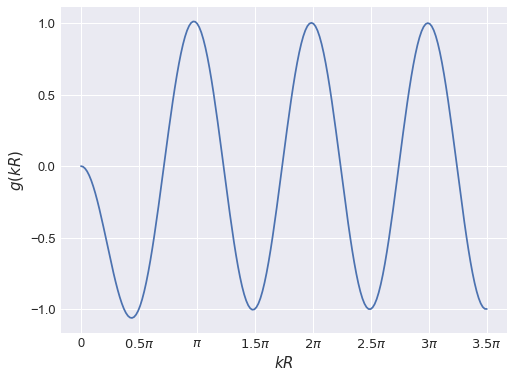

In [5]:
x = np.linspace(0.001, 3.5*np.pi, 200)
plt.plot(x, g(x))
plt.xticks(np.arange(0, 3.6*np.pi, np.pi/2), ['0', r'$0.5\pi$', r'$\pi$', r'$1.5\pi$', r'$2\pi$', r'$2.5\pi$', r'$3\pi$', r'$3.5\pi$'])
plt.xlabel(r'$kR$')
plt.ylabel(r'$g(kR)$')
plt.grid()

We use simple bisection to find root 6.

In [6]:
k = bisect(g, 3 * np.pi, 3.5 * np.pi) / l * 2

In [7]:
def init_m_sk(pos):
    x, y, _ = pos
    rho = (x**2 + y**2)**0.5
    phi = np.arctan2(y, x)

    m_phi = np.sin(k * rho)
    m_z = -np.cos(k * rho)

    return (-m_phi*np.sin(phi), m_phi*np.cos(phi), m_z)

In [8]:
system.m = df.Field(mesh, dim=3, value=init_m_sk, norm=384e3)

Initial magnetisation.

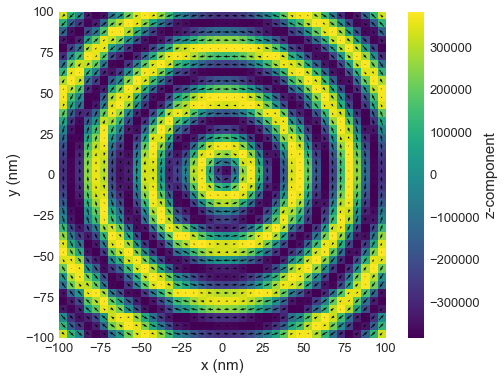

In [9]:
system.m.plane('z', n=(40, 40)).mpl()

We can now minimise the energy using OOMMF.

In [10]:
md = mc.MinDriver()
md.drive(system)

Running OOMMF (ExeOOMMFRunner) [2021/09/27 19:38]...  <1> mmarchive killed
 <2> mmarchive killed
(13.8 s)


After energy minimisation we find a state containing five skyrmions.

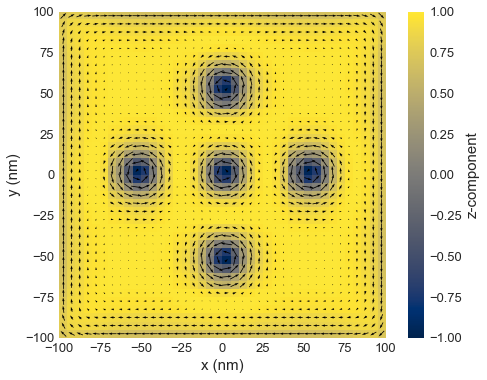

In [11]:
plane = system.m.orientation.plane(z=5e-9, n=(40,40))
plane.mpl(scalar_kwargs={'cmap': 'cividis', 'clim': [-1, 1]})

We can use `K3d` to get a 3D visualisation inside the notebook.

In [12]:
system.m.k3d.vector()

Output()

The final rendering is done with Blender. We export the magnetisation on one plane to `vtk`.

In [13]:
# system.m.orientation.plane(z=5e-9, n=(40,40)).write('skyrimons.vtk')

We can then create an artistic rendering in Blender (with full control over materials, lighting, camera positioning, ...):

![Rendering in Blender](sk-DoF.png)